In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd
import math
import time
from matplotlib.dates import MonthLocator, WeekdayLocator, WEEKLY, DateFormatter,rrulewrapper, RRuleLocator
import matplotlib.pylab as plt
from matplotlib import pyplot
%matplotlib inline

pd.options.display.max_columns = 100


Using TensorFlow backend.


## Weekly

In [2]:
df = pd.read_csv('Crime_Data.csv')
df = pd.DataFrame(df)
df.tail()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
489626,20180000320209,08/28/2018,8.0,08/28/2018,124.0,SEX OFFENSE-OTHER,SEXOFF-INDECENT LIBERTIES,SOUTH,R,R1,MID BEACON HILL
489627,20180000320316,08/28/2018,0.0,08/28/2018,322.0,CAR PROWL,THEFT-LICENSE PLATE,SOUTHWEST,F,F2,ROXHILL/WESTWOOD/ARBOR HEIGHTS
489628,20180000320203,08/28/2018,0.0,08/28/2018,57.0,AGGRAVATED ASSAULT,ASSLT-AGG-BODYFORCE,NORTH,L,L3,LAKECITY
489629,20070000430946,NaN,NaN,01/01/2007,NaN,RAPE,RAPE-OTHER,UNKNOWN,NaN,NaN,UNKNOWN
489630,19990000333737,NaN,NaN,01/01/1999,NaN,THEFT-SHOPLIFT,THEFT-SHOPLIFT,UNKNOWN,NaN,NaN,UNKNOWN


In [3]:
df = pd.read_csv('Crime_Data.csv')
df = pd.DataFrame(df)
df['date'] = pd.to_datetime(df['Occurred Date'],infer_datetime_format=True)
mask1 = (df['date'] > '2007-12-31') & (df['date'] < '2018-12-31')
df = df.loc[mask1] 
df = df[['Crime Subcategory', 'date']]
dfg = df.groupby(['date']).count()
dfg['date']=dfg.index
dfw = dfg.resample('W').sum()
dfw=dfw[1:]
dfw=dfw[:-1]
series = dfw['Crime Subcategory']
dfw.rename(columns={'Crime Subcategory': 'number_crimes'}, inplace=True)
dfw

,number_crimes
date,
2008-01-13,787
2008-01-20,743
2008-01-27,718
2008-02-03,657
2008-02-10,689
2008-02-17,755
2008-02-24,783
2008-03-02,786
2008-03-09,742


In [8]:
# Baseline:  Average Crimes/Week
train, test = series.values[0:-150], series.values[-150:]
pred_test_avg=test*0+train.mean()
pred_train_avg=train*0+train.mean()
rmse_test = sqrt(mean_squared_error(pred_test_avg, test))
rmse_train = sqrt(mean_squared_error(pred_train_avg, train))
print(rmse_test)
print(rmse_train)

122.79771625155772
84.6482478912366


RMSE: 68.003


<Figure size 432x288 with 0 Axes>

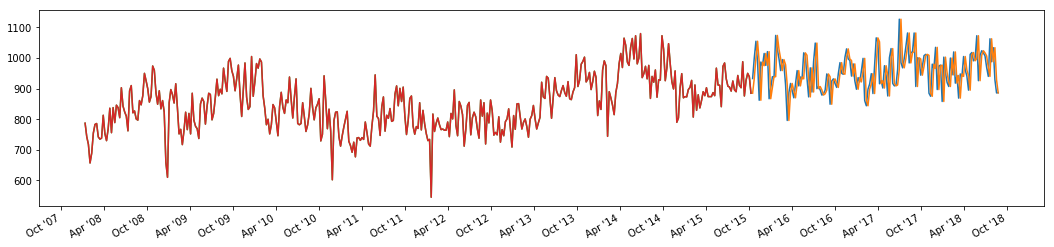

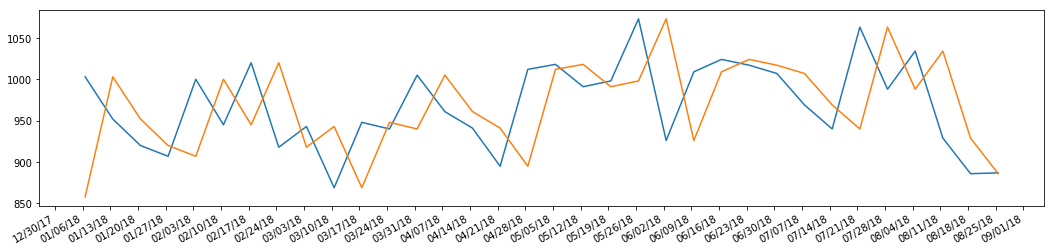

In [60]:
# Baseline:  Naive Model.  Today's Crime = Yesterday's Crime
X = series.values
train, test = X[0:-150], X[-150:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
    
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],test, '-',)
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[:-150],train, '-',)
ax.plot_date(dfw.index[:-150],history[:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],test[-34:], '-',)
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

Train Score: 59.764 RMSE
Test Score: 68.003 RMSE


<Figure size 432x288 with 0 Axes>

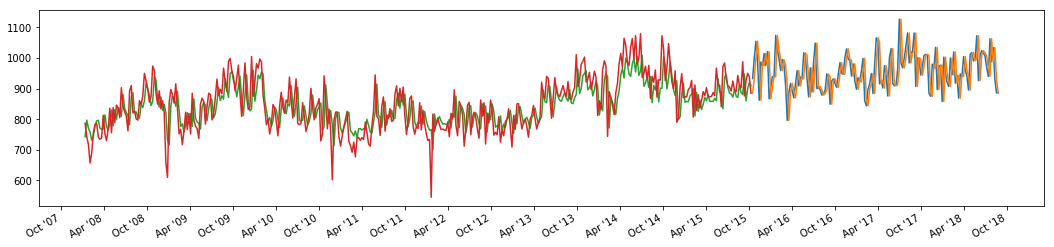

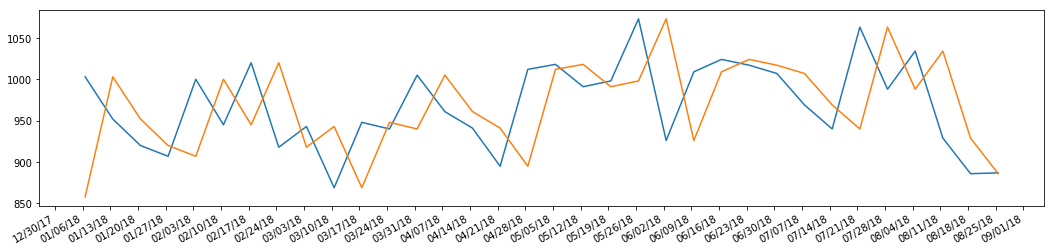

In [62]:
# LSTM with regression framing

np.random.seed(7)

def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, 1, X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1)
    return model

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# # load the dataset
# dataset = series.values
# dataset = dataset.astype('float32')

# supervised = timeseries_to_supervised(dataset, 1)
# supervised_values = supervised.values

# # split into train and test sets
# train, test = supervised_values[0:-150], supervised_values[-150:]

# # normalize the dataset
# scaler, train_scaled, test_scaled = scale(train, test)

# # fit the model
# lstm_model = fit_lstm(train_scaled, 1, 100, 1)

# # forecast the entire training dataset to build up state for forecasting
# train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
# lstm_model.predict(train_reshaped, batch_size=1)
 
# #walk-forward validation on the test data
# predictions = list()
# for i in range(len(test_scaled)):
# 	# make one-step forecast
# 	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
# 	yhat = forecast_lstm(lstm_model, 1, X)
# 	# invert scaling
# 	yhat = invert_scale(scaler, X, yhat)
# 	# store forecast
# 	predictions.append(yhat)
# 	expected = series.values[len(train) + i]
# 	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# predictions_train = list()
# for i in range(len(train_scaled)):
# 	# make one-step forecast
# 	X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
# 	yhat_train = forecast_lstm(lstm_model, 1, X_train)
# 	# invert scaling
# 	yhat_train = invert_scale(scaler, X_train, yhat_train)
# 	# store forecast
# 	predictions_train.append(yhat_train)

# report performance
trainScore = sqrt(mean_squared_error(series.values[:-150], predictions_train))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(series.values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-') #test real
ax.plot_date(dfw.index[-150:],predictions, '-') #test predict
ax.plot_date(dfw.index[:-150],predictions_train, '-',) #train predict
ax.plot_date(dfw.index[:-150],history[:-150], '-') #train real
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

Train Score: 128.569 RMSE
Test Score: 64.501 RMSE


<Figure size 432x288 with 0 Axes>

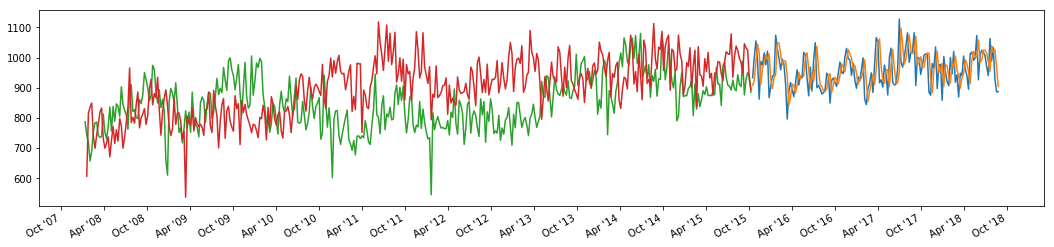

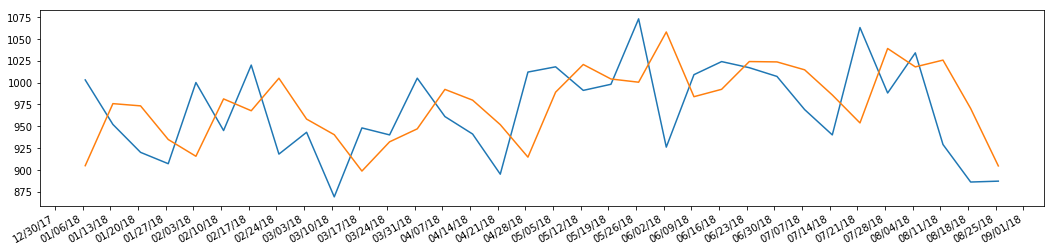

In [109]:
# LSTM with regression framing and stationarity

# np.random.seed(7)

# def timeseries_to_supervised(data, lag=1):
# 	df = DataFrame(data)
# 	columns = [df.shift(i) for i in range(1, lag+1)]
# 	columns.append(df)
# 	df = concat(columns, axis=1)
# 	df.fillna(0, inplace=True)
# 	return df
 
# # create a differenced series
# def difference(dataset, interval=1):
# 	diff = list()
# 	for i in range(interval, len(dataset)):
# 		value = dataset[i] - dataset[i - interval]
# 		diff.append(value)
# 	return Series(diff)

# # invert differenced value
# def inverse_difference(history, yhat, interval=1):
# 	return yhat + history[-interval]

# # scale train and test data to [-1, 1]
# def scale(train, test):
# 	# fit scaler
# 	scaler = MinMaxScaler(feature_range=(-1, 1))
# 	scaler = scaler.fit(train)
# 	# transform train
# 	train = train.reshape(train.shape[0], train.shape[1])
# 	train_scaled = scaler.transform(train)
# 	# transform test
# 	test = test.reshape(test.shape[0], test.shape[1])
# 	test_scaled = scaler.transform(test)
# 	return scaler, train_scaled, test_scaled

# # fit an LSTM network to training data
# def fit_lstm(train, batch_size, nb_epoch, neurons):
#     X, y = train[:, 0:-1], train[:, -1]
#     X = X.reshape(X.shape[0], 1, X.shape[1])
#     model = Sequential()
#     model.add(LSTM(neurons, batch_input_shape=(batch_size, 1, X.shape[2])))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1)
#     return model

# # inverse scaling for a forecasted value
# def invert_scale(scaler, X, value):
# 	new_row = [x for x in X] + [value]
# 	array = np.array(new_row)
# 	array = array.reshape(1, len(array))
# 	inverted = scaler.inverse_transform(array)
# 	return inverted[0, -1]

# # make a one-step forecast
# def forecast_lstm(model, batch_size, X):
# 	X = X.reshape(1, 1, len(X))
# 	yhat = model.predict(X, batch_size=batch_size)
# 	return yhat[0,0]

# # load the dataset
# # dataset = series.values
# # dataset = dataset.astype('float32')

# # transform data to be stationary
# raw_values = dataset
# diff_values = difference(raw_values, 1)

# supervised = timeseries_to_supervised(diff_values, 1)
# supervised_values = supervised.values

# # split into train and test sets
# train, test = supervised_values[0:-150], supervised_values[-150:]

# # normalize the dataset
# scaler, train_scaled, test_scaled = scale(train, test)

# # fit the model
# lstm_model = fit_lstm(train_scaled, 1, 100, 1)

# # forecast the entire training dataset to build up state for forecasting
# train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
# lstm_model.predict(train_reshaped, batch_size=1)
 
# #walk-forward validation on the test data
# predictions = list()
# for i in range(len(test_scaled)):
#     # make one-step forecast
#     X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
#     yhat = forecast_lstm(lstm_model, 1, X)
#     # invert scaling
#     yhat = invert_scale(scaler, X, yhat)
#     # invert differencing
#     yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
#     # store forecast
#     predictions.append(yhat)
#     expected = raw_values[len(train) + i+1]
#     print('Week=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat_train = forecast_lstm(lstm_model, 1, X_train)
    # invert scaling
    yhat_train = invert_scale(scaler, X_train, yhat_train)
    # invert differencing
    yhat_train = inverse_difference(raw_values, yhat_train, len(train_scaled)+1-i)
    # store forecast
    predictions_train.append(yhat_train)
    expected = series.values[i]
    
# report performance
trainScore = sqrt(mean_squared_error(raw_values[1:-150], predictions_train)) 
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(raw_values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-') #test true
ax.plot_date(dfw.index[-150:],predictions, '-') #test predict
ax.plot_date(dfw.index[:-150],series.values[:-150], '-',) # train 
ax.plot_date(dfw.index[1:-150],predictions_train, '-') #train predict !!!!!!
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()


In [ ]:
# LSTM with time-step window regression framing

np.random.seed(7)

def timeseries_to_supervised(data, lag=3):
	df = DataFrame(data)
	columns = [df.shift(i) for i in reversed(range(1, lag+1))]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:3], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1],1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=1, verbose=1)
    return model

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    #X = X.reshape(len(X))
    X = X.reshape(1,len(X),1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#load the dataset
dataset = series.values
dataset = dataset.astype('float32')

supervised = timeseries_to_supervised(dataset, 3)
supervised_values = supervised.values

# split into train and test sets
train, test = supervised_values[0:-150], supervised_values[-150:]

# normalize the dataset
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0:3].reshape(len(train_scaled), 3, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = series.values[len(train) + i]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
	yhat_train = forecast_lstm(lstm_model, 1, X_train)
	# invert scaling
	yhat_train = invert_scale(scaler, X, yhat_train)
	# store forecast
	predictions_train.append(yhat_train)
	expected = series.values[i]
    
# report performance
trainScore = sqrt(mean_squared_error(series.values[1:-150], predictions_train))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(series.values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-')
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[:-150],predictions_train, '-',)
ax.plot_date(dfw.index[:-150],series.values[:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

Epoch 1/1
405/405 [==============================] - 3s 8ms/step - loss: 0.0916
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0910
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0856
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0771
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0661
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0577
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0550
Epoch 1/1
405/405 [==============================] - 1s 4ms/step - loss: 0.0541
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0536A: 0s - loss: 0.05
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0532
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0530
Epoch 1/1
405/405 [==============================] - 2s 5ms/step - loss: 0.0528
Epoch 1/1
405/405 [===

Day=119, Predicted=932.104614, Expected=920.000000
Day=120, Predicted=943.782227, Expected=907.000000
Day=121, Predicted=936.482117, Expected=1000.000000
Day=122, Predicted=934.298218, Expected=945.000000
Day=123, Predicted=935.892639, Expected=1020.000000
Day=124, Predicted=950.027344, Expected=918.000000
Day=125, Predicted=947.238220, Expected=943.000000
Day=126, Predicted=951.101135, Expected=869.000000
Day=127, Predicted=934.731934, Expected=948.000000
Day=128, Predicted=930.247803, Expected=940.000000
Day=129, Predicted=922.990417, Expected=1005.000000
Day=130, Predicted=935.984253, Expected=961.000000
Day=131, Predicted=942.220764, Expected=941.000000
Day=132, Predicted=949.674561, Expected=895.000000
Day=133, Predicted=941.912781, Expected=1012.000000
Day=134, Predicted=939.729736, Expected=1018.000000
Day=135, Predicted=941.919861, Expected=991.000000
Day=136, Predicted=957.693848, Expected=998.000000
Day=137, Predicted=962.016052, Expected=1073.000000
Day=138, Predicted=964.10

<Figure size 432x288 with 0 Axes>

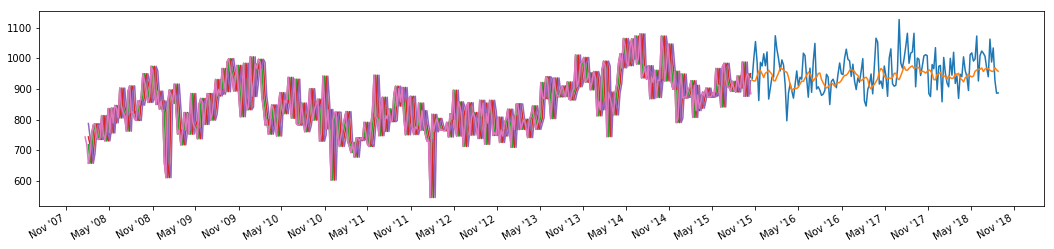

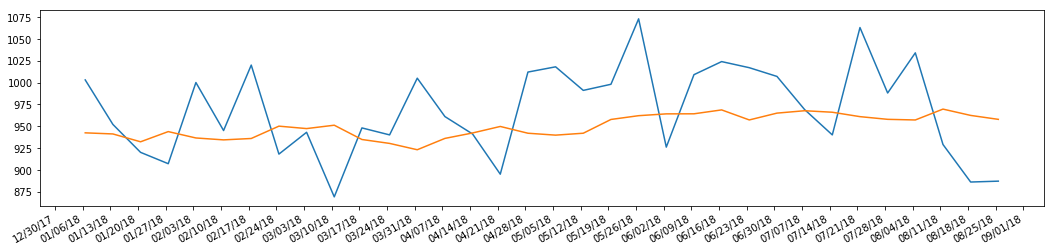

In [120]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=3):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:3], train[:, -1]
	X = X.reshape(X.shape[0], X.shape[1], 1)
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1,len(X),1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#load the dataset
dataset = series.values
dataset = dataset.astype('float32')

# transform data to be supervised learning
supervised = timeseries_to_supervised(dataset, 3)
supervised_values = supervised.values

# split into train and test sets
train, test = supervised_values[0:-150], supervised_values[-150:]

# normalize the dataset
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0:3].reshape(len(train_scaled), 3, 1)
lstm_model.predict(train_reshaped, batch_size=1)

#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = series.values[len(train) + i]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
	yhat_train = forecast_lstm(lstm_model, 1, X_train)
	# invert scaling
	yhat_train = invert_scale(scaler, X, yhat_train)
	# store forecast
	predictions_train.append(yhat_train)
	expected = series.values[i]

# report performance
trainScore = sqrt(mean_squared_error(series.values[:-150], predictions_train))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(series.values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-')
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[:-150],predictions_train, '-',)
ax.plot_date(dfw.index[:-150],series.values[1:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

Epoch 1/1
405/405 [==============================] - 4s 10ms/step - loss: 0.0866
Epoch 1/1
405/405 [==============================] - 3s 7ms/step - loss: 0.0862
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0779
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0668
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0579
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0546
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0538
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0535
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0533
Epoch 1/1
405/405 [==============================] - 3s 6ms/step - loss: 0.0532
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0530
Epoch 1/1
405/405 [==============================] - 3s 6ms/step - loss: 0.0529
Epoch 1/1
405/405 [====================

Day=97, Predicted=971.449768, Expected=1017.000000
Day=98, Predicted=972.051697, Expected=1021.000000
Day=99, Predicted=969.797119, Expected=1082.000000
Day=100, Predicted=971.860596, Expected=907.000000
Day=101, Predicted=968.756897, Expected=1001.000000
Day=102, Predicted=965.218384, Expected=997.000000
Day=103, Predicted=959.161072, Expected=944.000000
Day=104, Predicted=955.750061, Expected=973.000000
Day=105, Predicted=953.717285, Expected=1008.000000
Day=106, Predicted=953.358948, Expected=1012.000000
Day=107, Predicted=957.065735, Expected=1009.000000
Day=108, Predicted=961.716492, Expected=885.000000
Day=109, Predicted=957.227600, Expected=875.000000
Day=110, Predicted=943.081848, Expected=980.000000
Day=111, Predicted=930.971558, Expected=966.000000
Day=112, Predicted=930.275940, Expected=1035.000000
Day=113, Predicted=944.534363, Expected=897.000000
Day=114, Predicted=947.839661, Expected=974.000000
Day=115, Predicted=948.629822, Expected=977.000000
Day=116, Predicted=945.899

<Figure size 432x288 with 0 Axes>

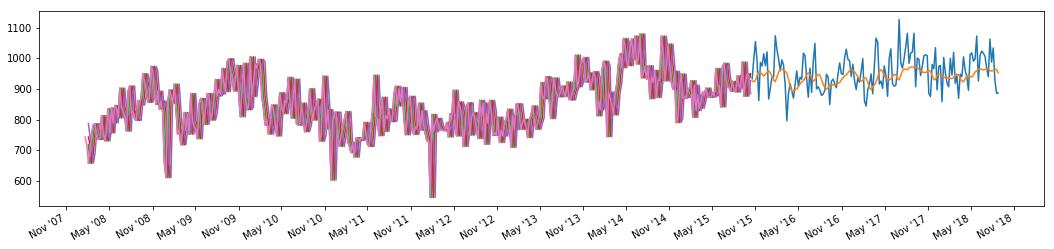

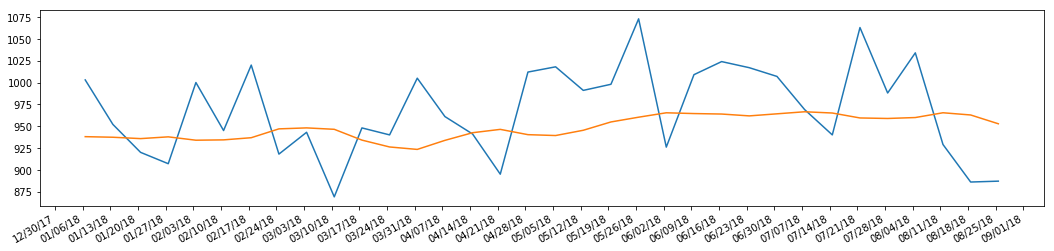

In [80]:
# frame a sequence as a stacked supervised learning problem
def timeseries_to_supervised(data, lag=3):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:3], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True, return_sequences=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1,len(X),1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#load the dataset
dataset = series.values
dataset = dataset.astype('float32')

# transform data to be supervised learning
supervised = timeseries_to_supervised(dataset, 3)
supervised_values = supervised.values

# split into train and test sets
train, test = supervised_values[0:-150], supervised_values[-150:]

# normalize the dataset
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0:3].reshape(len(train_scaled), 3, 1)
lstm_model.predict(train_reshaped, batch_size=1)

#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = series.values[len(train) + i]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
	yhat_train = forecast_lstm(lstm_model, 1, X_train)
	# invert scaling
	yhat_train = invert_scale(scaler, X, yhat_train)
	# store forecast
	predictions_train.append(yhat_train)
	expected = series.values[i]

# report performance
trainScore = sqrt(mean_squared_error(series.values[:-150], predictions_train))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(series.values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-')
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[:-150],predictions_train, '-',)
ax.plot_date(dfw.index[:-150],series.values[:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

Epoch 1/1
405/405 [==============================] - 4s 10ms/step - loss: 0.0896
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0878
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0842
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0779
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0688
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0600
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0573
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0576
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0577
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0576
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0576
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0575
Epoch 1/1
405/405 [====================

Day=85, Predicted=938.760315, Expected=1031.000000
Day=86, Predicted=939.248901, Expected=917.000000
Day=87, Predicted=942.087463, Expected=909.000000
Day=88, Predicted=942.273071, Expected=912.000000
Day=89, Predicted=939.260315, Expected=963.000000
Day=90, Predicted=938.240967, Expected=1127.000000
Day=91, Predicted=940.677307, Expected=985.000000
Day=92, Predicted=943.521667, Expected=968.000000
Day=93, Predicted=946.586243, Expected=999.000000
Day=94, Predicted=944.452087, Expected=1038.000000
Day=95, Predicted=944.422974, Expected=1082.000000
Day=96, Predicted=945.520203, Expected=984.000000
Day=97, Predicted=946.375610, Expected=1017.000000
Day=98, Predicted=946.877686, Expected=1021.000000
Day=99, Predicted=945.313416, Expected=1082.000000
Day=100, Predicted=946.027405, Expected=907.000000
Day=101, Predicted=945.982117, Expected=1001.000000
Day=102, Predicted=946.424438, Expected=997.000000
Day=103, Predicted=943.669128, Expected=944.000000
Day=104, Predicted=944.998718, Expecte

<Figure size 432x288 with 0 Axes>

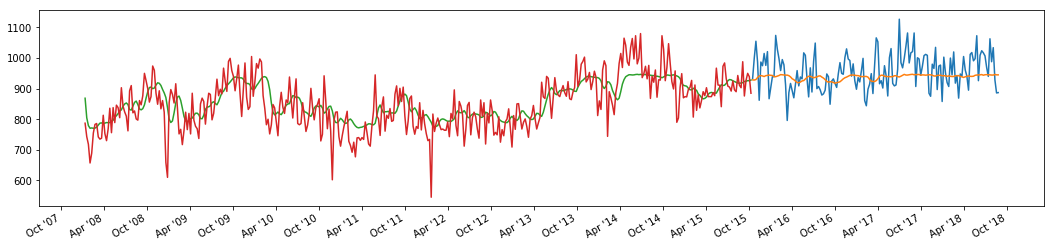

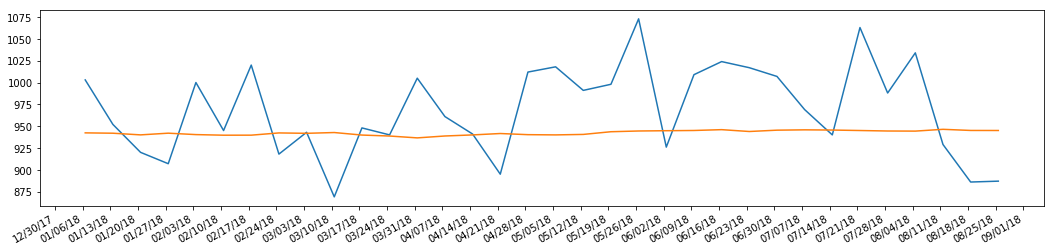

In [56]:
# frame a sequence as a stacked supervised learning problem:  RMSProp instead of Adam
def timeseries_to_supervised(data, lag=3):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:3], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True, return_sequences=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='RMSProp')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1,len(X),1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#load the dataset
dataset = series.values
dataset = dataset.astype('float32')

# transform data to be supervised learning
supervised = timeseries_to_supervised(dataset, 3)
supervised_values = supervised.values

# split into train and test sets
train, test = supervised_values[0:-150], supervised_values[-150:]

# normalize the dataset
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0:3].reshape(len(train_scaled), 3, 1)
lstm_model.predict(train_reshaped, batch_size=1)

#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = series.values[len(train) + i]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
	yhat_train = forecast_lstm(lstm_model, 1, X_train)
	# invert scaling
	yhat_train = invert_scale(scaler, X_train, yhat_train)
	# store forecast
	predictions_train.append(yhat_train)
	expected = series.values[i]

# report performance
trainScore = sqrt(mean_squared_error(series.values[:-150], predictions_train))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(series.values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-')
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[:-150],predictions_train, '-',)
ax.plot_date(dfw.index[:-150],series.values[:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

Epoch 1/1
405/405 [==============================] - 4s 9ms/step - loss: 0.0968
Epoch 1/1
405/405 [==============================] - 2s 5ms/step - loss: 0.1006
Epoch 1/1
405/405 [==============================] - 2s 5ms/step - loss: 0.0998
Epoch 1/1
405/405 [==============================] - 2s 5ms/step - loss: 0.0983
Epoch 1/1
405/405 [==============================] - 2s 5ms/step - loss: 0.0960
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0922
Epoch 1/1
405/405 [==============================] - 3s 6ms/step - loss: 0.0858
Epoch 1/1
405/405 [==============================] - 3s 7ms/step - loss: 0.0760
Epoch 1/1
405/405 [==============================] - 3s 6ms/step - loss: 0.0664
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0610
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0595
Epoch 1/1
405/405 [==============================] - 2s 6ms/step - loss: 0.0597
Epoch 1/1
405/405 [=====================

Day=111, Predicted=917.401306, Expected=966.000000
Day=112, Predicted=926.714966, Expected=1035.000000
Day=113, Predicted=930.398987, Expected=897.000000
Day=114, Predicted=931.394165, Expected=974.000000
Day=115, Predicted=922.472229, Expected=977.000000
Day=116, Predicted=927.665405, Expected=858.000000
Day=117, Predicted=923.856323, Expected=1003.000000
Day=118, Predicted=918.479736, Expected=952.000000
Day=119, Predicted=928.377075, Expected=920.000000
Day=120, Predicted=924.493591, Expected=907.000000
Day=121, Predicted=920.071716, Expected=1000.000000
Day=122, Predicted=922.067444, Expected=945.000000
Day=123, Predicted=928.578003, Expected=1020.000000
Day=124, Predicted=928.259766, Expected=918.000000
Day=125, Predicted=930.496216, Expected=943.000000
Day=126, Predicted=922.832703, Expected=869.000000
Day=127, Predicted=920.119263, Expected=948.000000
Day=128, Predicted=916.227722, Expected=940.000000
Day=129, Predicted=922.380676, Expected=1005.000000
Day=130, Predicted=925.839

<Figure size 432x288 with 0 Axes>

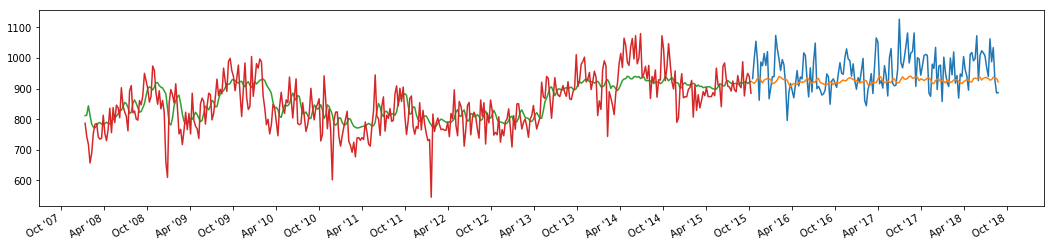

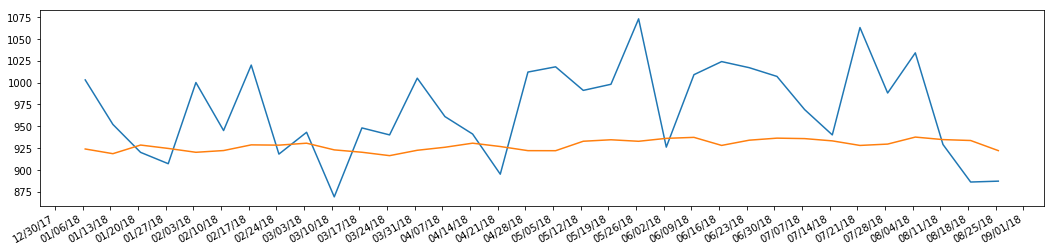

--- 316.441734790802 seconds ---


In [10]:
# frame a sequence as a stacked supervised learning problem:  2 lag, not 3, 150 epochs
start_time = time.time()


def timeseries_to_supervised(data, lag=2):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:2], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True, return_sequences=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1,len(X),1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#load the dataset
dataset = series.values
dataset = dataset.astype('float32')

# transform data to be supervised learning
supervised = timeseries_to_supervised(dataset,2)
supervised_values = supervised.values

# split into train and test sets
train, test = supervised_values[0:-150], supervised_values[-150:]

# normalize the dataset
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 150, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0:2].reshape(len(train_scaled), 2, 1)
lstm_model.predict(train_reshaped, batch_size=1)

#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = series.values[len(train) + i]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
	yhat_train = forecast_lstm(lstm_model, 1, X_train)
	# invert scaling
	yhat_train = invert_scale(scaler, X, yhat_train)
	# store forecast
	predictions_train.append(yhat_train)
	expected = series.values[i]

# report performance
trainScore = sqrt(mean_squared_error(series.values[:-150], predictions_train))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(series.values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-')
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[:-150],predictions_train, '-',)
ax.plot_date(dfw.index[:-150],series.values[:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/1
405/405 [==============================] - 3s 9ms/step - loss: 0.1321
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1145
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1091
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1064
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1049
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1040
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1034
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1030
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1028
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1026
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1025
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.1024
Epoch 1/1
405/405 [=====================

Day=124, Predicted=965.873779, Expected=918.000000
Day=125, Predicted=946.561584, Expected=943.000000
Day=126, Predicted=944.182007, Expected=869.000000
Day=127, Predicted=911.051941, Expected=948.000000
Day=128, Predicted=928.877502, Expected=940.000000
Day=129, Predicted=934.751038, Expected=1005.000000
Day=130, Predicted=956.802734, Expected=961.000000
Day=131, Predicted=955.468445, Expected=941.000000
Day=132, Predicted=948.284729, Expected=895.000000
Day=133, Predicted=926.271118, Expected=1012.000000
Day=134, Predicted=954.576904, Expected=1018.000000
Day=135, Predicted=969.360229, Expected=991.000000
Day=136, Predicted=970.105957, Expected=998.000000
Day=137, Predicted=972.227966, Expected=1073.000000
Day=138, Predicted=985.768311, Expected=926.000000
Day=139, Predicted=964.214783, Expected=1009.000000
Day=140, Predicted=972.298401, Expected=1024.000000
Day=141, Predicted=979.339600, Expected=1017.000000
Day=142, Predicted=981.379822, Expected=1007.000000
Day=143, Predicted=980.

<Figure size 432x288 with 0 Axes>

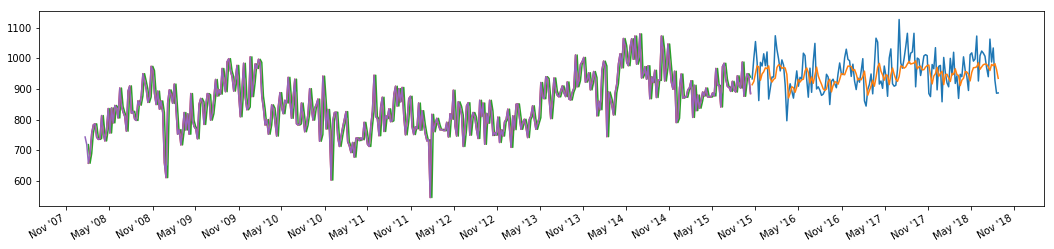

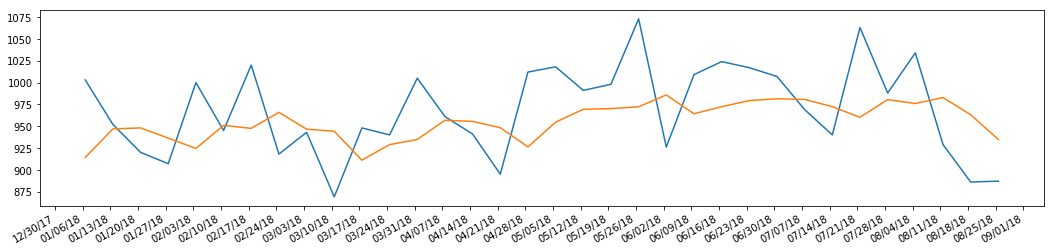

In [212]:
# frame a sequence as a stacked supervised learning problem:  1 lag, not 3, 150 epochs
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:1], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True, return_sequences=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1,1,len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#load the dataset
dataset = series.values
dataset = dataset.astype('float32')

# transform data to be supervised learning
supervised = timeseries_to_supervised(dataset,1)
supervised_values = supervised.values

# split into train and test sets
train, test = supervised_values[0:-150], supervised_values[-150:]

# normalize the dataset
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 150, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = series.values[len(train) + i]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
	yhat_train = forecast_lstm(lstm_model, 1, X_train)
	# invert scaling
	yhat_train = invert_scale(scaler, X, yhat_train)
	# store forecast
	predictions_train.append(yhat_train)
	expected = series.values[i]

# report performance
trainScore = sqrt(mean_squared_error(series.values[:-150], predictions_train))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(series.values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-')
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[:-150],predictions_train, '-',)
ax.plot_date(dfw.index[:-150],series.values[:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

Epoch 1/1
405/405 [==============================] - 6s 15ms/step - loss: 0.0913
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0903
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0844
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0754
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0651
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0588
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0570
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0560
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0552
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0545
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0539
Epoch 1/1
405/405 [==============================] - 1s 4ms/step - loss: 0.0533
Epoch 1/1
405/405 [====================

Train Score: 57.796 RMSE
Test Score: 57.272 RMSE


<Figure size 432x288 with 0 Axes>

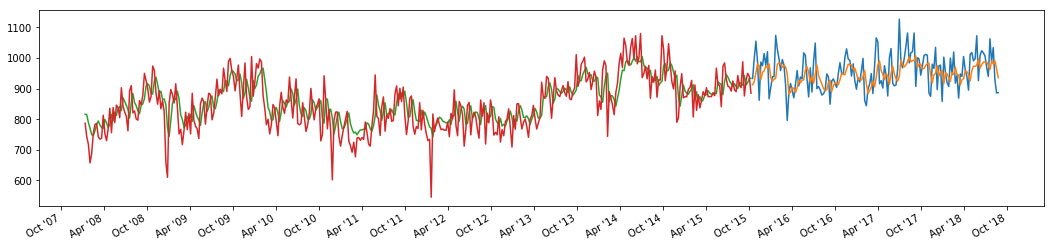

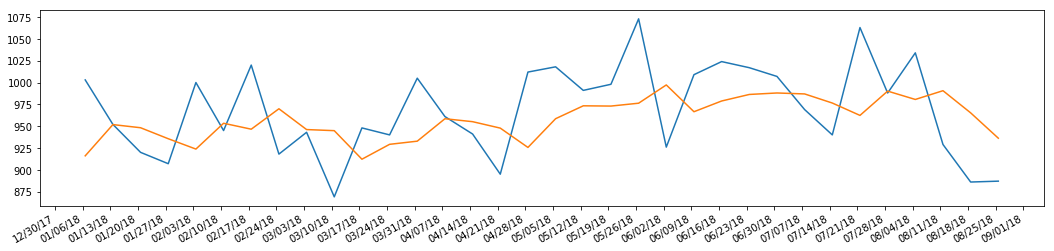

In [290]:
# frame a sequence as a supervised learning problem:  1 lag, not 3, 150 epochs
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:1], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1,1,len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#load the dataset
dataset = series.values
dataset = dataset.astype('float32')

# transform data to be supervised learning
supervised = timeseries_to_supervised(dataset,1)
supervised_values = supervised.values

# split into train and test sets
train, test = supervised_values[0:-150], supervised_values[-150:]

# normalize the dataset
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 150, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i,0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = series.values[len(train) + i]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
	yhat_train = forecast_lstm(lstm_model, 1, X_train)
	# invert scaling
	yhat_train = invert_scale(scaler, X_train, yhat_train)
	# store forecast
	predictions_train.append(yhat_train)
	expected = series.values[i]

# report performance
trainScore = sqrt(mean_squared_error(series.values[:-150], predictions_train))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(series.values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-')
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[:-150],predictions_train, '-',)
ax.plot_date(dfw.index[:-150],series.values[:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

<Figure size 432x288 with 0 Axes>

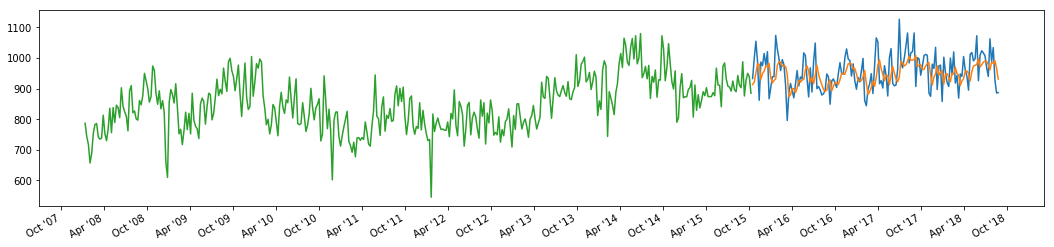

In [282]:
# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-')
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[:-150],predictions_train, '-',)
ax.plot_date(dfw.index[:-150],series.values[:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

# #2018 Only
# rule = rrulewrapper(WEEKLY, interval=1)
# loc = RRuleLocator(rule)
# formatter = DateFormatter('%m/%d/%y')

# fig, ax = plt.subplots(figsize=(18,4))
# ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
# ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
# ax.xaxis.set_major_locator(loc)
# ax.xaxis.set_major_formatter(formatter)
# ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# ax.autoscale_view()
# fig.autofmt_xdate()
# plt.show()

In [12]:
weather2 = pd.read_csv('1452977.csv')
weather1 = pd.read_csv('1465173.csv')
weather = pd.concat([weather1,weather2])
weather['date'] = pd.to_datetime(weather['DATE'],infer_datetime_format=True)
mask1 = (weather['date'] >'2008-01-07') & (weather['date'] <'2018-08-26')
w = weather.loc[mask1] 
w = w[['date', 'HOURLYPrecip', 'HOURLYDRYBULBTEMPF']]
w['date'] = pd.to_datetime(w['date'].dt.date)

#Replacing values with "s" in them with NA
#Replacing "Trace" precipitation with 0
replacements = {
   'HOURLYDRYBULBTEMPF': {
      r'(.*s)': np.NaN,
      r'(\*)': np.NaN}
}
w.replace(replacements, regex=True, inplace=True)

replacements = {
   'HOURLYPrecip': {
      r'(.*s)': np.NaN,
    r'T': 0.00}
}
w.replace(replacements, regex=True, inplace=True)
w['temp'] = [float(x) for x in w['HOURLYDRYBULBTEMPF']]
w['prec'] = [float(x) for x in w['HOURLYPrecip']]
# wgroup = w.groupby('dateonly')['prec'].mean()
# wgroup = w.groupby('dateonly')['temp'].mean()
wgroup = w.groupby('date')['prec','temp'].mean()
wgroup['date']=wgroup.index
wgroupw = wgroup.resample('W').mean()
dfplus = dfw.join(wgroupw)
dfplus.interpolate(inplace=True)
dfplus

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,11,12,13,14,15,16,17,19,20,23,25,26,27,28,29,33,34,44,45,46,47,72,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (26,27,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,number_crimes,prec,temp
date,,,
2008-01-13,787,0.008951,42.161250
2008-01-20,743,0.002260,37.983367
2008-01-27,718,0.001154,33.490916
2008-02-03,657,0.003296,38.048619
2008-02-10,689,0.006571,43.034533
2008-02-17,755,0.000179,43.063881
2008-02-24,783,0.000000,44.080252
2008-03-02,786,0.001662,47.138508
2008-03-09,742,0.000563,44.696328


In [13]:
dfplus.to_csv('dfplus.csv')

In [201]:
dfplus.head()

,number_crimes,prec,temp
date,,,
2008-01-13,787,0.008951,42.161250
2008-01-20,743,0.002260,37.983367
2008-01-27,718,0.001154,33.490916
2008-02-03,657,0.003296,38.048619
2008-02-10,689,0.006571,43.034533


In [ ]:
# Multi - value
# frame a sequence as a supervised learning problemc
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:3], train[:, 3]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

#load data
dataset = dfplus.values
dataset = dataset.astype('float32')

# transform data to be supervised learning
supervised = timeseries_to_supervised(dataset, 1)
supervised = supervised.iloc[:,0:4]
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-150], supervised_values[-150:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0:3].reshape(len(train_scaled), 1, 3)
lstm_model.predict(train_reshaped, batch_size=1)
       
#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:3], test_scaled[i, 3]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = series.values[len(train) + i]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X_train, y_train = train_scaled[i, 0:3], train_scaled[i, 3]
	yhat_train = forecast_lstm(lstm_model, 1, X_train)
	# invert scaling
	yhat_train = invert_scale(scaler, X_train, yhat_train)
	# store forecast
	predictions_train.append(yhat_train)
	expected = series.values[i]

# report performance
trainScore = sqrt(mean_squared_error(series.values[:-150], predictions_train))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(series.values[-150:], predictions))
print('Test Score: %.3f RMSE' % (testScore))


Epoch 1/1
405/405 [==============================] - 3s 8ms/step - loss: 0.1913
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.1314
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.1135
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.1019
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0920
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0827
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0737
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0652
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0579
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0528
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0497
Epoch 1/1
405/405 [==============================] - 1s 3ms/step - loss: 0.0481
Epoch 1/1
405/405 [=====================

Day=128, Predicted=916.664917, Expected=940.000000
Day=129, Predicted=920.875916, Expected=1005.000000
Day=130, Predicted=951.896851, Expected=961.000000
Day=131, Predicted=947.691589, Expected=941.000000
Day=132, Predicted=941.782471, Expected=895.000000
Day=133, Predicted=923.412537, Expected=1012.000000
Day=134, Predicted=955.907410, Expected=1018.000000
Day=135, Predicted=971.040588, Expected=991.000000
Day=136, Predicted=967.364197, Expected=998.000000
Day=137, Predicted=969.025696, Expected=1073.000000
Day=138, Predicted=992.736267, Expected=926.000000
Day=139, Predicted=953.518921, Expected=1009.000000
Day=140, Predicted=967.298645, Expected=1024.000000
Day=141, Predicted=978.104980, Expected=1017.000000
Day=142, Predicted=979.322998, Expected=1007.000000
Day=143, Predicted=979.238831, Expected=969.000000
Day=144, Predicted=964.475220, Expected=940.000000
Day=145, Predicted=948.406860, Expected=1063.000000
Day=146, Predicted=982.213928, Expected=988.000000
Day=147, Predicted=970

<Figure size 432x288 with 0 Axes>

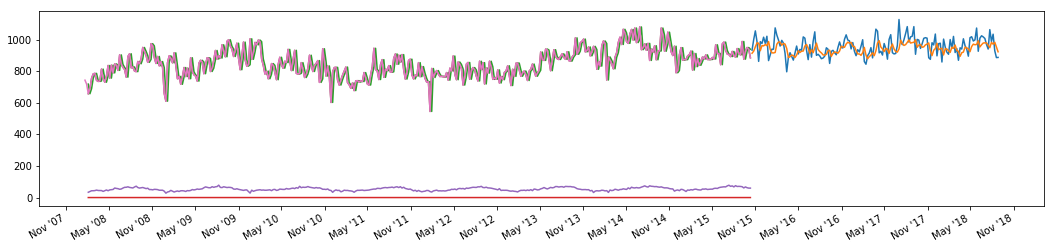

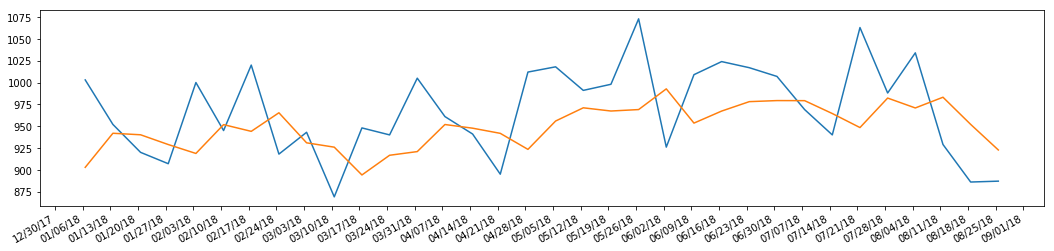

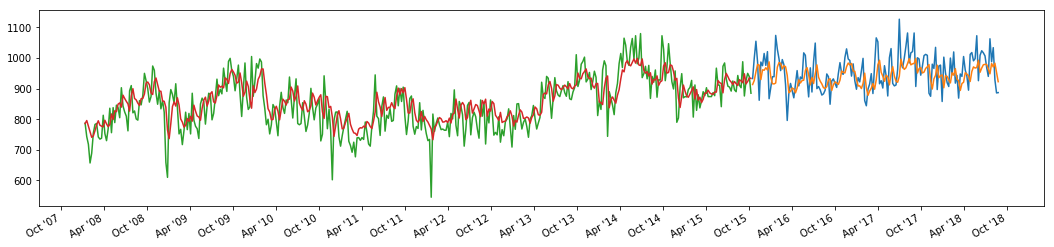

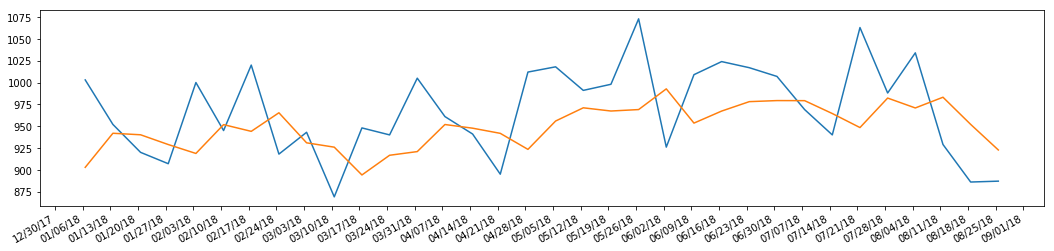

In [269]:
fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-') # test real
ax.plot_date(dfw.index[-150:],predictions, '-') # test predict
ax.plot_date(dfw.index[:-150],series.values[:-150], '-') #train real
ax.plot_date(dfw.index[:-150],predictions_train, '-') # train predict
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-')
ax.plot_date(dfw.index[-34:],predictions[-34:], '-')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

In [264]:
dfw

,number_crimes
date,
2008-01-13,787
2008-01-20,743
2008-01-27,718
2008-02-03,657
2008-02-10,689
2008-02-17,755
2008-02-24,783
2008-03-02,786
2008-03-09,742


## Crime Histograms

In [5]:
dfcrimetype = df['Crime Subcategory'].value_counts()
dfcrimetype = pd.DataFrame(dfcrimetype)

<Figure size 432x288 with 0 Axes>

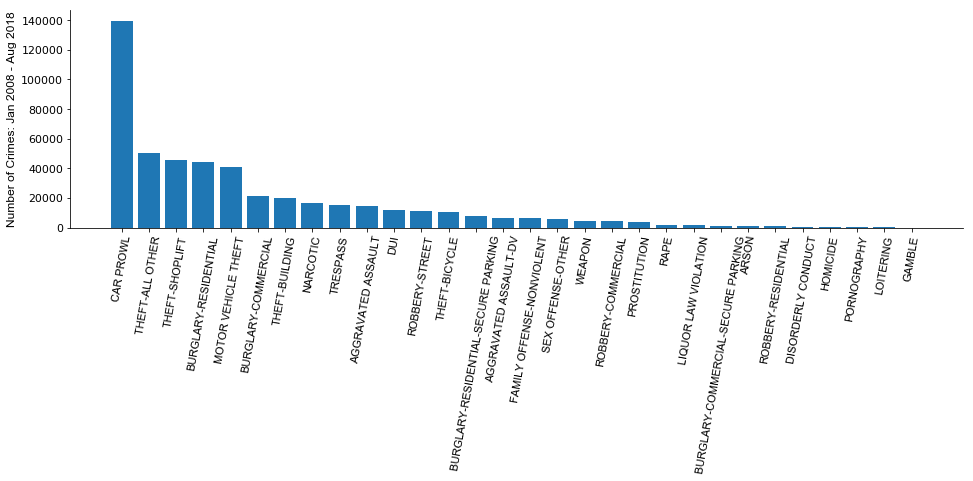

In [17]:
dfcrimetype.rename(columns={'Crime Subcategory': 'Number'}, inplace=True)
dfcrimetype['Crime']=dfcrimetype.index
# dfcrimetype_sorted = dfcrimetype.sort_values('Number',ascending=False)

plt.clf()
plt.figure(figsize=[16,4])
y_pos = np.arange(len(dfcrimetype['Crime']))

# plt.title('Number of Crimes by Type')
ax = plt.subplot(111)

from matplotlib import axes
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xticks(y_pos, dfcrimetype['Crime'], rotation = 80, **{'fontname':'Arial'})
plt.ylabel('Number of Crimes: Jan 2008 - Aug 2018', {'family': 'Arial', 'fontsize': 12 })
plt.tick_params(axis='both', which='major', labelsize=11)
plt.bar(y_pos,dfcrimetype['Number'] )
plt.show()



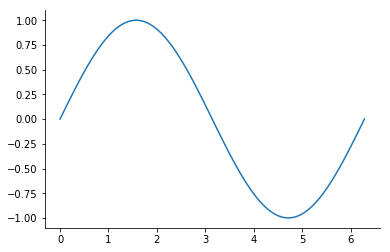

In [18]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

ax = plt.subplot(111)
ax.plot(x, y)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

In [61]:
dfcrimetype

,Number,Crime
CAR PROWL,139687,CAR PROWL
THEFT-ALL OTHER,50346,THEFT-ALL OTHER
THEFT-SHOPLIFT,45494,THEFT-SHOPLIFT
BURGLARY-RESIDENTIAL,44430,BURGLARY-RESIDENTIAL
MOTOR VEHICLE THEFT,40994,MOTOR VEHICLE THEFT
BURGLARY-COMMERCIAL,21624,BURGLARY-COMMERCIAL
THEFT-BUILDING,19938,THEFT-BUILDING
NARCOTIC,16636,NARCOTIC
TRESPASS,15264,TRESPASS
AGGRAVATED ASSAULT,14273,AGGRAVATED ASSAULT


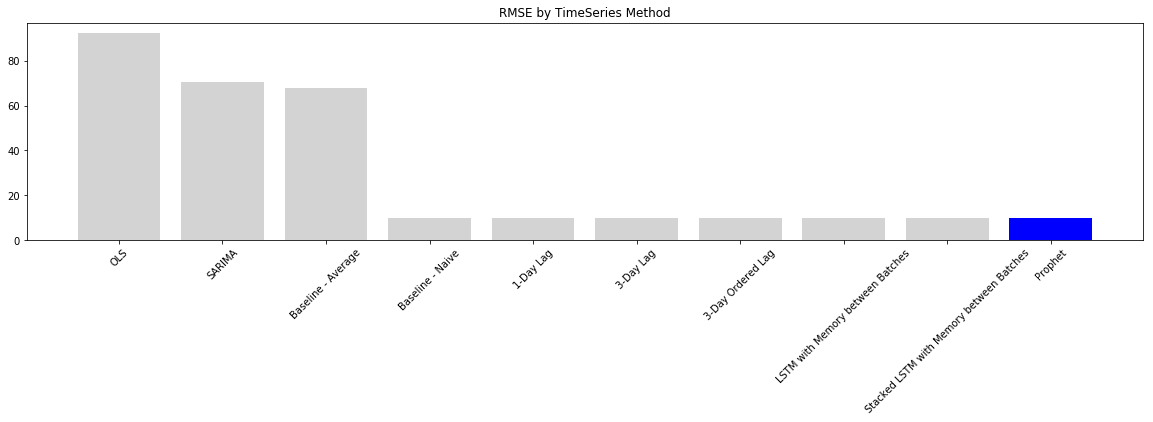

In [240]:
df = pd.DataFrame(read_csv('rmse_histogram.csv'))
df=df.iloc[:,0:2]
df.dropna(inplace=True, axis=0)
df.columns = ['Method','RMSE']
df.index = df['Method']
df_sorted = df.sort_values('RMSE',ascending=False)
#df.iloc[:,0]
plt.figure(figsize=[20,4])
colors = ['lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray','lightgray',
         'lightgray','blue',]
y_pos = np.arange(len(df['Method']))
plt.xticks(y_pos,df['Method'], rotation = 45)
plt.bar(y_pos,df_sorted['RMSE'], color = colors, )
plt.title('RMSE by TimeSeries Method')
plt.show()

In [45]:
df_sorted

,Method,RMSE
Method,,
Baseline - Average,Baseline - Average,92.120
1-Day Lag,1-Day Lag,70.298
Baseline - Naive,Baseline - Naive,68.003
OLS,OLS,10.000
SARIMA,SARIMA,10.000
3-Day Lag,3-Day Lag,10.000
3-Day Ordered Lag,3-Day Ordered Lag,10.000
LSTM with Memory between Batches,LSTM with Memory between Batches,10.000
Stacked LSTM with Memory between Batches,Stacked LSTM with Memory between Batches,10.000


In [1]:
df.head()

NameError: name 'df' is not defined

# EVERYTHING BELOW IS CRAP

In [242]:
#####Don't use!!

# Baseline:  Naive Model.  Today's Crime = Yesterday's Crime
X = series.values
train, test = X[0:-150], X[-150:]
# walk-forward validation
history = [x for x in train]
predictionsn = list()
for i in range(len(test)):
	# make prediction
	predictionsn.append(history[-1])
	# observation
	history.append(test[i])
    
predictionsn




[885,
 933,
 1000,
 1055,
 987,
 862,
 987,
 975,
 1015,
 976,
 1021,
 867,
 903,
 939,
 939,
 1074,
 1029,
 998,
 959,
 995,
 978,
 912,
 796,
 887,
 917,
 894,
 870,
 915,
 959,
 909,
 938,
 932,
 1017,
 1009,
 933,
 873,
 968,
 889,
 989,
 1049,
 900,
 907,
 896,
 879,
 883,
 895,
 948,
 939,
 849,
 925,
 932,
 917,
 904,
 949,
 985,
 950,
 947,
 1002,
 1030,
 997,
 992,
 941,
 981,
 926,
 898,
 936,
 922,
 958,
 999,
 861,
 844,
 898,
 915,
 949,
 884,
 978,
 1066,
 1053,
 916,
 926,
 902,
 975,
 943,
 876,
 1001,
 1031,
 917,
 909,
 912,
 963,
 1127,
 985,
 968,
 999,
 1038,
 1082,
 984,
 1017,
 1021,
 1082,
 907,
 1001,
 997,
 944,
 973,
 1008,
 1012,
 1009,
 885,
 875,
 980,
 966,
 1035,
 897,
 974,
 977,
 858,
 1003,
 952,
 920,
 907,
 1000,
 945,
 1020,
 918,
 943,
 869,
 948,
 940,
 1005,
 961,
 941,
 895,
 1012,
 1018,
 991,
 998,
 1073,
 926,
 1009,
 1024,
 1017,
 1007,
 969,
 940,
 1063,
 988,
 1034,
 929,
 886]

In [243]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:1], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True, return_sequences=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1,1,len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#load the dataset
dataset = series.values
dataset = dataset.astype('float32')

# transform data to be supervised learning
supervised = timeseries_to_supervised(dataset,1)
supervised_values = supervised.values

# split into train and test sets
train, test = supervised_values[0:-150], supervised_values[-150:]

# normalize the dataset
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 150, 1)

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# store forecast
	predictions.append(yhat)
	expected = series.values[len(train) + i]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

predictions_train = list()
for i in range(len(train_scaled)):
	# make one-step forecast
	X_train, y_train = train_scaled[i, 0:-1], train_scaled[i, -1]
	yhat_train = forecast_lstm(lstm_model, 1, X_train)
	# invert scaling
	yhat_train = invert_scale(scaler, X, yhat_train)
	# store forecast
	predictions_train.append(yhat_train)
	expected = series.values[i]

# line plot of observed vs predicted
plt.clf()
months    = MonthLocator(range(1,13), bymonthday=1, interval=6)
monthsFmt = DateFormatter("%b '%y")

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-150:],series.values[-150:], '-')
ax.plot_date(dfw.index[-150:],predictions, '-')
ax.plot_date(dfw.index[3:-150],train[3:], '-',)
ax.plot_date(dfw.index[1:-150],series.values[1:-150], '-')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()

#2018 Only
rule = rrulewrapper(WEEKLY, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

fig, ax = plt.subplots(figsize=(18,4))
ax.plot_date(dfw.index[-34:],series.values[-34:], '-', linewidth = 1.0)
ax.plot_date(dfw.index[-34:],predictions[-34:], '-', linewidth = 2.0)
ax.plot_date(dfw.index[-34:],predictionsn[-34:], '-', color = 'grey', linewidth = 0.4)

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.autoscale_view()
fig.autofmt_xdate()
plt.show()


Epoch 1/1
405/405 [==============================] - 4s 11ms/step - loss: 0.0970
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0949
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0907
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0824
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0718
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0652
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0633
Epoch 1/1
405/405 [==============================] - 2s 4ms/step - loss: 0.0627
Epoch 1/1
405/405 [==============================] - 2s 5ms/step - loss: 0.0621
Epoch 1/1
405/405 [==============================] - 2s 5ms/step - loss: 0.0613
Epoch 1/1
405/405 [==============================] - 2s 5ms/step - loss: 0.0604
Epoch 1/1
405/405 [==============================] - 2s 5ms/step - loss: 0.0595
Epoch 1/1
405/405 [====================

Day=114, Predicted=944.357605, Expected=974.000000
Day=115, Predicted=951.865295, Expected=977.000000
Day=116, Predicted=958.225281, Expected=858.000000
Day=117, Predicted=906.618591, Expected=1003.000000
Day=118, Predicted=946.468384, Expected=952.000000
Day=119, Predicted=948.906494, Expected=920.000000
Day=120, Predicted=935.084412, Expected=907.000000
Day=121, Predicted=919.262207, Expected=1000.000000
Day=122, Predicted=950.672241, Expected=945.000000
Day=123, Predicted=948.554443, Expected=1020.000000
Day=124, Predicted=968.045654, Expected=918.000000
Day=125, Predicted=948.902771, Expected=943.000000
Day=126, Predicted=942.895630, Expected=869.000000
Day=127, Predicted=900.595642, Expected=948.000000
Day=128, Predicted=925.720215, Expected=940.000000
Day=129, Predicted=933.117004, Expected=1005.000000
Day=130, Predicted=958.234192, Expected=961.000000
Day=131, Predicted=958.553040, Expected=941.000000
Day=132, Predicted=949.568542, Expected=895.000000
Day=133, Predicted=920.4349

<Figure size 432x288 with 0 Axes>

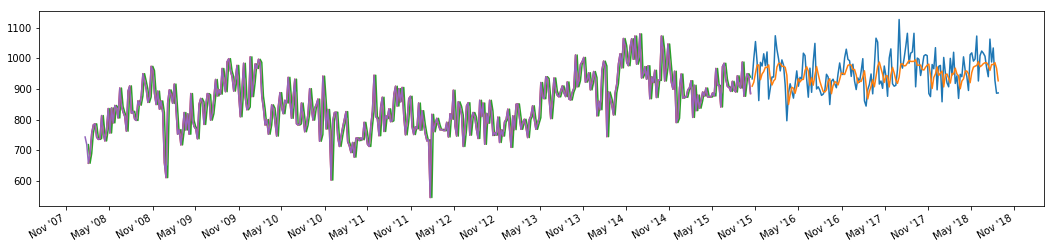

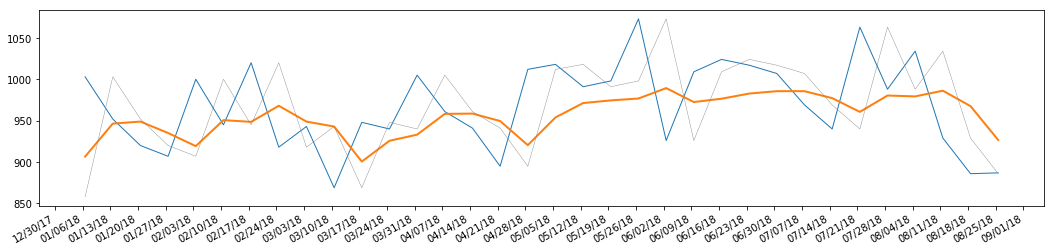

In [284]:
len(train_scaled)

405

In [272]:
predictions_train

[949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,
 949.7385,